# Rapport Data Challenge 

#### Antoine Boulat, 07/03/2021

A travers ce rapport, je tenterai de manière concise de vous présentez la méthodologie que j'ai suivi afin de réaliser le data challenge.

Tout le long de ce rapport, j'integrerai une partie du code que j'ai écrit. J'y inserrerai le code qui me semble le plus utile et qui m'a permit d'obtenir un score d'AUC d'environ 0.9.

J'integrerai aussi quelques pistes que j'ai exploré et qui n'ont pas abouti. 

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Extraction du train et test set

Cette partie permet l'extraction dans un dataframe pandas des données issues des csv fournit par Valeo. On peut noter l'ajout d'un dataframe xfull contenant xtrain et xtest.

In [2]:
xtrain = pd.read_csv("valeo_xtrain.csv")
ytrain = pd.read_csv("valeo_ytrain.csv")
xtest = pd.read_csv("valeo_xtest.csv")

xfull = pd.concat([xtrain, xtest], ignore_index=True)

# Exploration des données à l'aide de Pandas

In [3]:
xfull.head(20)

,START2_OP020_V_1angle,START2_OP020_V_1torque,START2_OP020_V_2angle,START2_OP020_V_2torque,START2_OP040_Vision_cosseprog,START2_OP050_Vision_paliermodel,START2_OP050_Vision_palierpresencedouille,START2_OP060_Vision_tirantcouleur,START2_OP070_V_1angle,START2_OP070_V_1prog,START2_OP070_V_1torque,START2_OP070_V_2angle,START2_OP070_V_2prog,START2_OP070_V_2torque,START2_OP080_Vision_rondelleprog,START2_OP090_MaxMidForceLimit,START2_OP090_MinMidForceLimit,START2_OP090_SnapRingFinalStroke,START2_OP090_SnapRingMidPointForce,START2_OP090_SnapRingPeakForce,START2_OP090_StartLinePeakForce,START2_OP100_Capuchon_insertionmesure,START2_OP110_Vissage_M8angle,START2_OP110_Vissage_M8prog,START2_OP110_Vissage_M8torque,START2_OP120_RodageI_mesure,START2_OP120_RodageU_mesure
0,35.7,3.76,49.1,3.78,300.0,1.0,1.0,2.0,111.7,8.0,6.61,110.1,8.0,6.61,3.0,140.0,50.0,11.60,71.52,122.23,20.57,0.55,34.7,2.0,9.54,126.96,11.97
1,47.2,3.77,50.3,3.76,30.0,1.0,1.0,2.0,106.0,8.0,6.60,111.4,8.0,6.60,3.0,140.0,50.0,11.82,67.38,163.78,18.73,0.55,38.7,2.0,9.54,133.88,11.97
2,52.7,3.78,40.4,3.78,300.0,1.0,1.0,2.0,103.4,8.0,6.64,112.1,8.0,6.62,3.0,140.0,50.0,11.86,89.09,207.73,26.39,0.55,30.2,2.0,9.66,135.28,11.97
3,34.9,3.77,34.9,3.78,1000.0,2.0,1.0,1.0,146.0,7.0,6.42,133.0,7.0,6.42,10.0,140.0,50.0,11.47,93.45,177.31,25.73,0.59,17.6,1.0,12.06,116.51,11.97
4,50.0,3.77,41.9,3.75,400.0,1.0,1.0,2.0,115.8,8.0,6.63,130.5,8.0,6.61,4.0,140.0,50.0,11.88,85.17,174.73,21.50,0.42,52.0,1.0,12.12,140.92,11.98
5,34.9,3.75,32.1,3.78,7.0,2.0,1.0,1.0,147.2,7.0,6.41,157.9,7.0,6.40,7.0,140.0,50.0,11.65,75.53,147.62,44.69,0.41,17.0,1.0,12.16,117.53,11.97
6,30.6,3.75,48.4,3.77,300.0,1.0,1.0,2.0,92.7,8.0,6.62,115.8,8.0,6.60,3.0,140.0,50.0,11.74,91.41,188.79,33.50,0.54,32.8,2.0,9.61,133.02,11.97
7,44.9,3.76,49.8,3.75,300.0,1.0,1.0,2.0,96.6,8.0,6.62,103.7,8.0,6.60,3.0,140.0,50.0,11.90,91.99,225.70,27.52,0.54,26.1,2.0,9.60,136.84,11.97
8,35.6,3.80,34.3,3.79,1300.0,2.0,1.0,1.0,143.5,7.0,6.42,163.0,7.0,6.42,13.0,140.0,50.0,11.75,88.64,186.74,26.87,0.23,14.3,1.0,12.28,115.13,11.97
9,31.5,3.79,32.8,3.77,700.0,2.0,1.0,1.0,149.9,7.0,6.41,155.1,7.0,6.42,7.0,140.0,50.0,11.54,76.29,124.27,27.53,0.40,11.1,1.0,12.32,112.94,11.97


Une simple lecture des premieres lignes du dataset permet de se rendre compte qu'il existe des données continues (Exemple : START2_OP020_V_1angle, colonne 0) et d'autre qui ne prennent que certaines valeurs, discretes (Exemple : START2_OP050_Vision_paliermodel, colonne 5).

Dans la suite nous allons transformer nos dataframe en tableau numpy pour poursuivre l'extraction des données.

In [4]:
y_train = ytrain.to_numpy().ravel()
X_train = xtrain.to_numpy()
X_test = xtest.to_numpy()
X_full = xfull.to_numpy()

A l'aide de la fonction numpy np.unique() nous pouvons observer le nombre de lignes duppliqué dans le dataset.

Pour des raisons de commodité, mon rapport ne reflete pas l'évolution chronologique de mon traitement du data challenge. Je me suis rendu compte très tard qu'il y avait des lignes duppliquées et que chacune (ou presque, sauf 4) de ces lignes duppliquées a un label "anomalie" et "normal". Il m'a resté très peu de temps à la fin du challenge pour pouvoir retravailler la partie sur la selection du modèle.

Le code suivant démontre de l'existence de ligne duppliquées.

In [5]:
len(X_full) - len(np.unique(X_full, axis=0))

1400

J'ai tenté différentes approches pour ces lignes duppliquées (supprimé toutes les lignes duppliqué, supprimé un exemplaire de ces lignes duppliqués, leur affecté à toutes un label "normal" ou toutes "anomalie". 

Finalement, ce qui a le mieux fonctionné a été de les discriminées. Nous ajouterons donc une colonne avec 0 si c'est une ligne non duppliqué et 1 si elle l'est.

In [12]:
# la fonction np.unique conserve un exemplaire des lignes en double
# or nous voulons connaitres toutes les lignes en double pour construire
# notre colonne supplémentaire

def add_column_dupplicate(X):
    X_reduce = np.unique(X, axis=0, return_inverse=True)
    k=0
    indexes = []
    for x in X_reduce[1] : 
        if np.count_nonzero(X_reduce[1] == x) > 1 :
            indexes.append(1)
        else :
            indexes.append(0)
        k += 1
    indexes = np.array(indexes)
    X = np.hstack((X, indexes.reshape(-1,1)))
    return X

In [13]:
X_train = add_column_dupplicate(X_train)
print(X_train.shape)
print(y_train.shape)
X_test = add_column_dupplicate(X_test)
print(X_test.shape)
X_full = add_column_dupplicate(X_full)
print(X_full.shape)

(27586, 19)
(27586,)
(27587, 19)
(55173, 19)


Finalement, pour la suite nous pourrons avoir besoin de donner non standardisé. Je conserve donc une copie des dataset X_train et X_test. De plus, j'extrait les indices des données contenant des anomalies.

In [6]:
index = ytrain[ytrain['Anomaly']==0].index.tolist()
index_anomally = ytrain[ytrain['Anomaly']==1].index.tolist()

X_train_full = np.copy(X_train)
X_normal = X_train_full[index]
X_anomally = X_train_full[index_anomally]

X_test_full = np.copy(X_test)

# Standardisation

Cette partie me permet de standardiser les données. La plupart des modèles et des opérations de visualisation et d'exploration des données demandent des données standardisées.

Néanmoins, on fera attention de ne pas standardiser des données pour certains modèles, typiquement les modèles de type naive Bayes.

#### Standard scaling

In [11]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_full)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_full = scaler.transform(X_full)

print(X_train.shape)
print(X_test.shape)
print(X_full.shape)

(27586, 18)
(27587, 18)
(55173, 18)


Une alternative que je trouve interessant au standard scaling est le robust scaling de sklearn moins dépendant aux outliers (ce dernier se base sur les quantile pour standardiser les données).

En pratique et pour cette problématique, les scores d'AUC ne sont pas très différents.

#### Robust scaling

In [85]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X_full)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_full = scaler.transform(X_full)

print(X_train.shape)
print(X_test.shape)
print(X_full.shape)

(27259, 27)
(27587, 27)
(55173, 27)


# Matrice de corrélation et extraction de features

Dans cette partie, je commence par afficher la matrice de corrélation afin d'observer le degré de corrélation entre les différentes features.

Ca me permet visuellement de commencer à comprendre les relations entre les features et ainsi d'observer si il est possible de d'extraire des features.

#### Matrice de corrélation

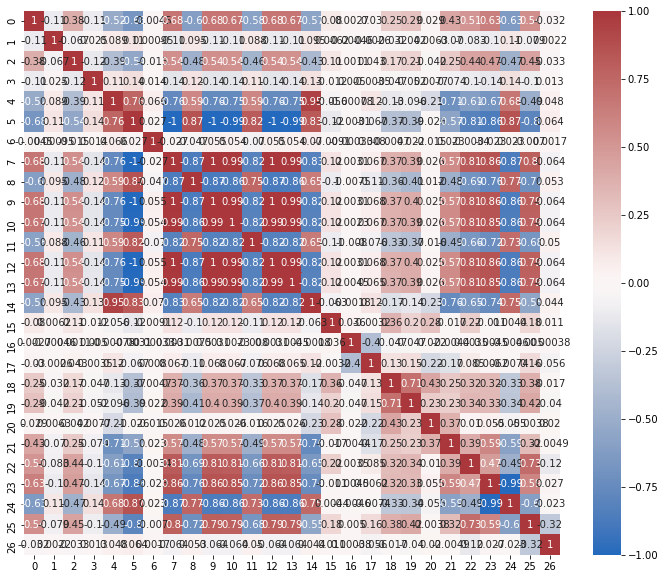

In [44]:
df = pd.DataFrame(X_train[:,:27])
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap='vlag')
plt.show()

Remarque : je ne prends pas en compte la colonne 27, celle que j'ai contruite pour discriminer les lignes duppliquées.

#### Feature selection

Cette partie se concentre sur la selection de features. Deux approches sont envisagés : d'une part, on peut supprimé les variables fortement corrélées. D'autre part, j'ai tenté une recursive feature elimination (RFECV de scikit learn). J'ai choisi un estimateur de type support vector machine munit d'un noyau RBF car lors de mes premiers tests, c'était le modèle "simple" qui fittait le mieux à mes données, j'ai donc pris ce modèle pour selectionné les variable les plus explicatives.

J'ai obtenu de meilleurs performance en supprimant simplement les variables les plus corrélés (corrélation  > 0.85, à part la derniere colonne que j'ai créé pour la discrimination des lignes duppliqués).

##### Suppression des variables les plus corrélés

In [10]:
xfull = pd.DataFrame(X_full)
xtrain = pd.DataFrame(X_train)
xtest = pd.DataFrame(X_test)

corr_matrix = xfull.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

xfull = xfull.drop(to_drop, axis=1)
xtrain = xtrain.drop(to_drop, axis=1)
xtest = xtest.drop(to_drop, axis=1)

X_train = xtrain.to_numpy()
X_test = xtest.to_numpy()
X_full = xfull.to_numpy()

print(X_train.shape)
print(X_test.shape)
print(X_full.shape)

(27586, 18)
(27587, 18)
(55173, 18)


##### Linéaire

In [5]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="rbf")

selector = RFE(estimator, n_features_to_select=20)
selector.fit(X_train, y_train)
select_features = np.argsort(selector.ranking_)[:21]
print(select_features)
X_train = X_train[:,select_features]
X_test = X_test[:,select_features]
X_full = X_full[:,select_features]

# Observation des données

Nous passons à une étape importante de la méthodologie pour traiter un dataset : la data visualisation.

Nous commencerons par afficher la distribution des variables sur les données non normalisé. 

Dans la première série de plot, j'affiche : la distribution du train set sur les pièces "normal", la distribution du train set sur les pièces possédant une anomalie et enfin la distribtion du test set.

Dans la seconde série de plot, j'affiche la distribution des données du train set en comparaison de celle du test set afin de voir si il y a une différence de distribution entre les deux (donc un biais), ce qui nous donnerait des indices pour traiter la problématique. 

#### Observation de la distribution des feature

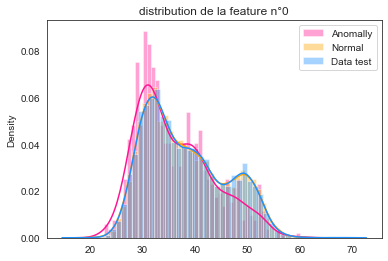

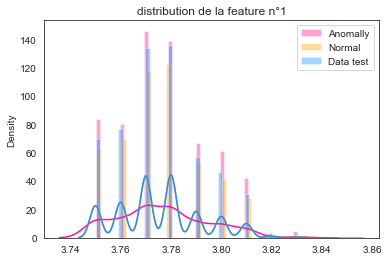

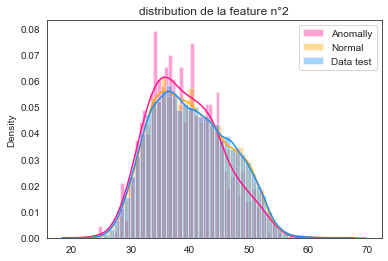

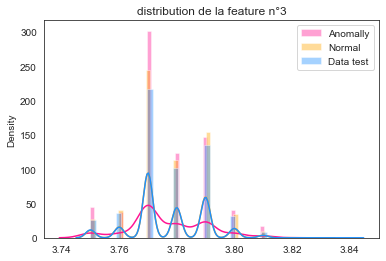

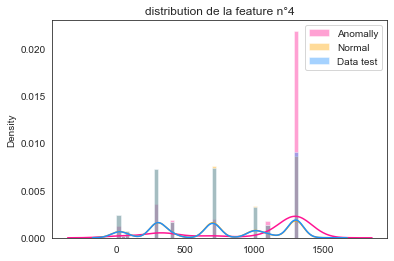

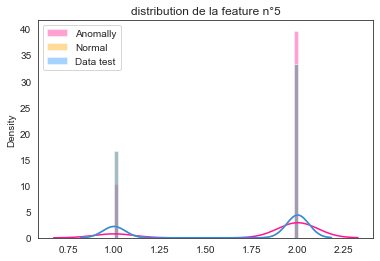

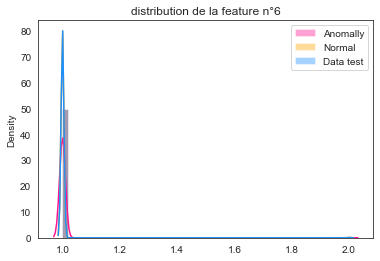

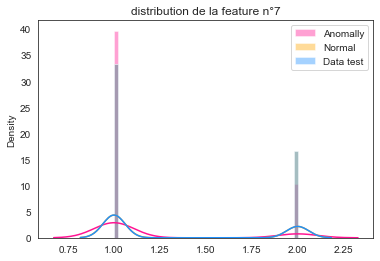

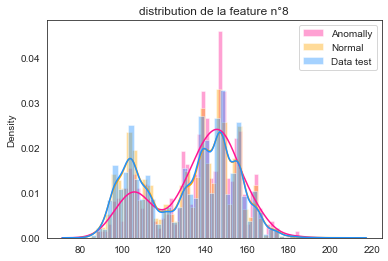

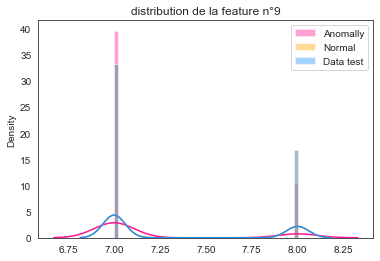

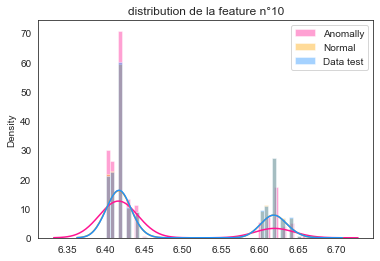

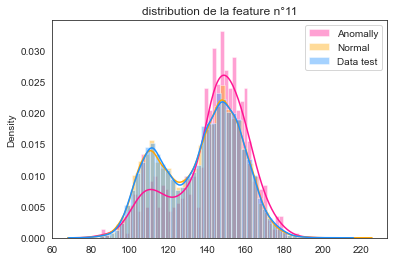

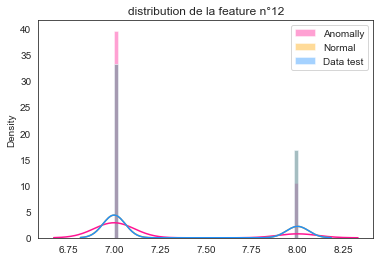

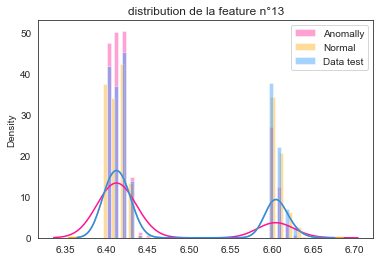

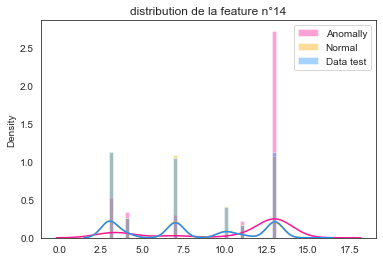

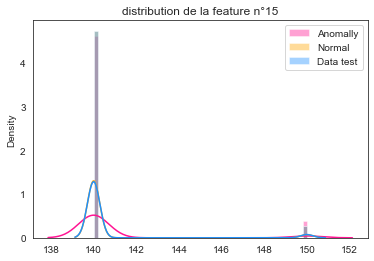

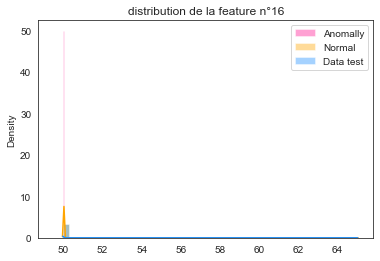

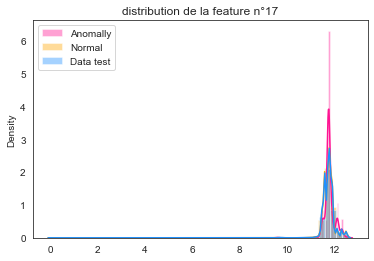

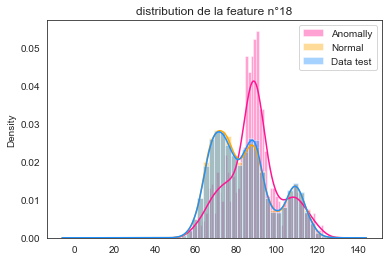

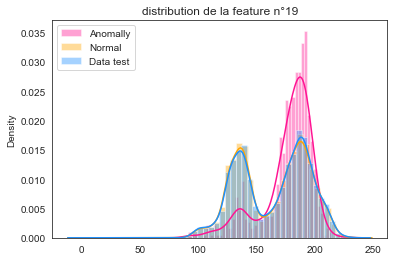

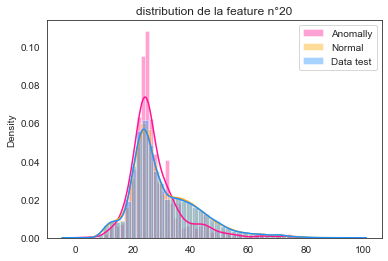

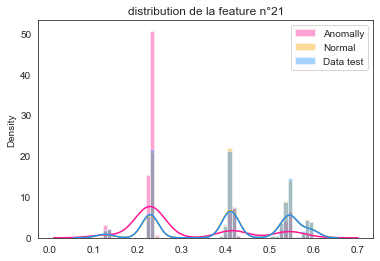

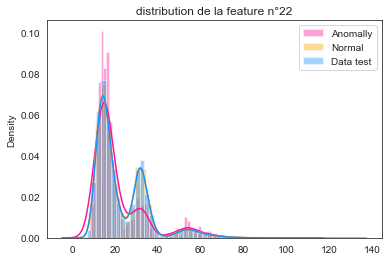

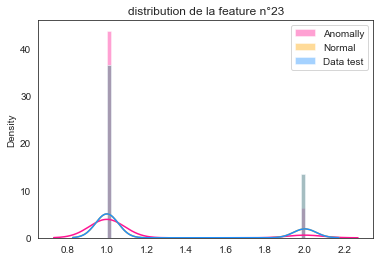

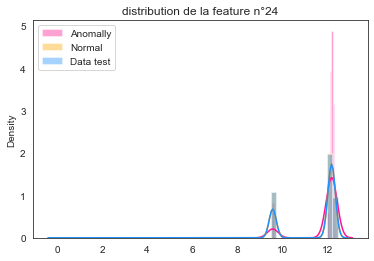

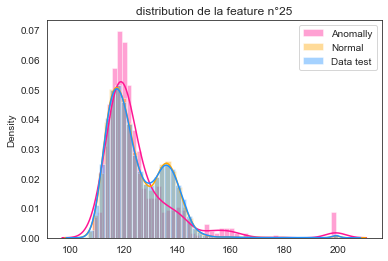

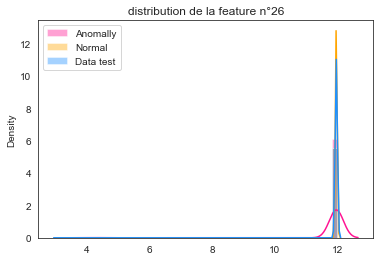

In [7]:
import seaborn as sns
sns.set_style("white")

i = 0
for k in X_test.T :
    bins = 50
    sns.distplot(X_anomally[:,i], bins = bins, color="deeppink", label="Anomally")
    sns.distplot(X_normal[:,i], bins = bins, color="orange", label="Normal")
    sns.distplot(X_test_full[:,i], bins = bins, color="dodgerblue", label="Data test")
    plt.title("distribution de la feature n°" + str(i))
    plt.legend()
    plt.show()
    i +=1

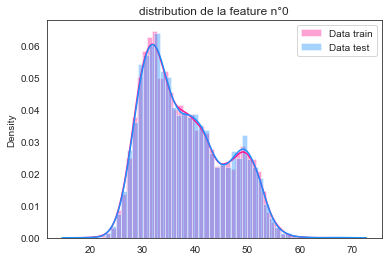

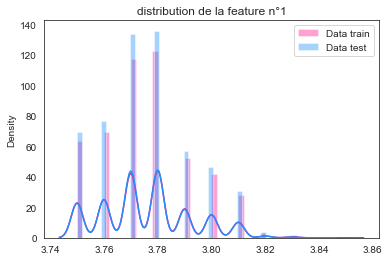

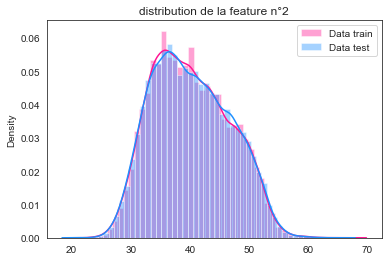

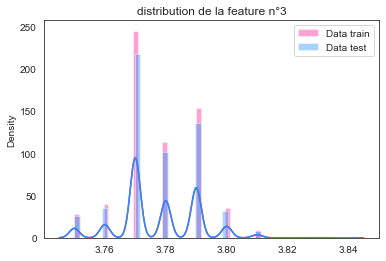

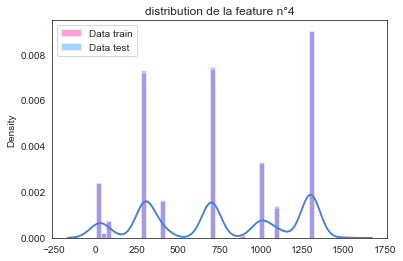

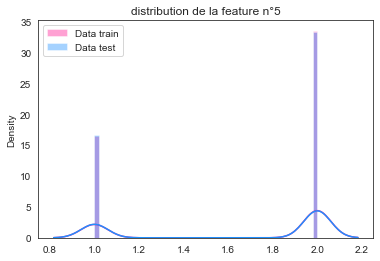

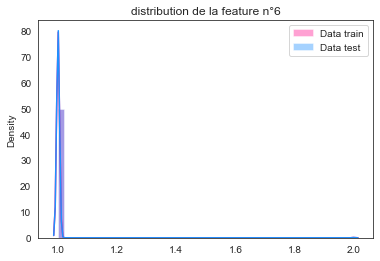

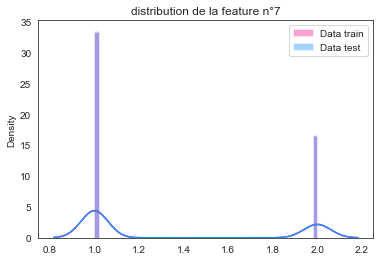

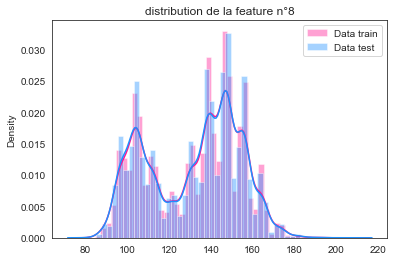

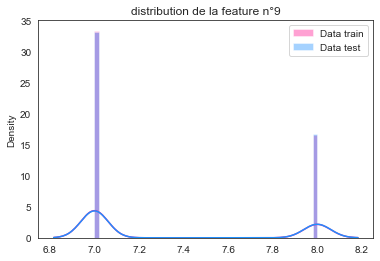

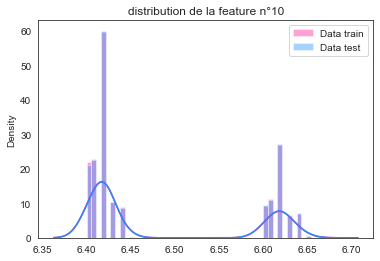

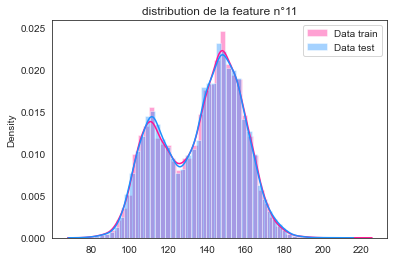

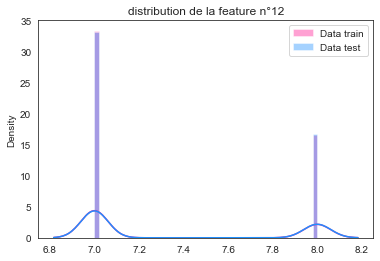

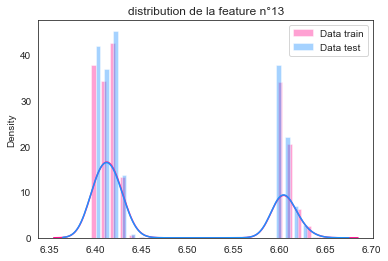

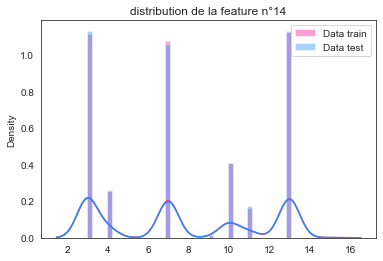

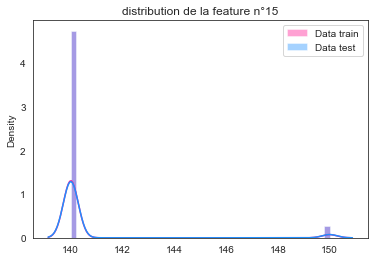

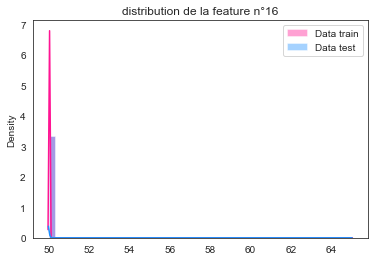

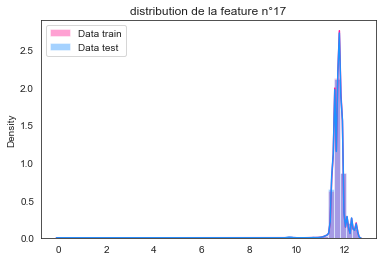

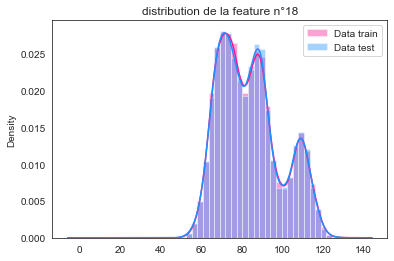

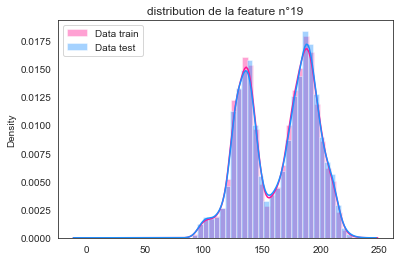

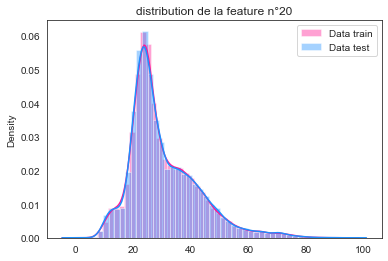

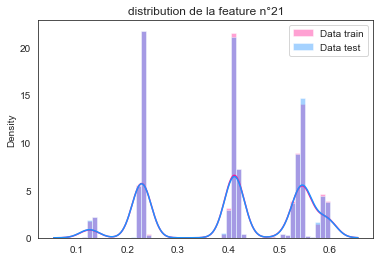

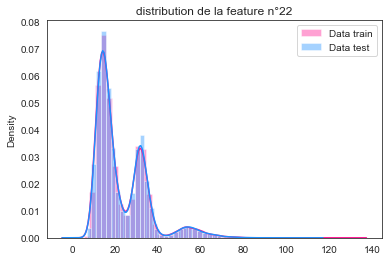

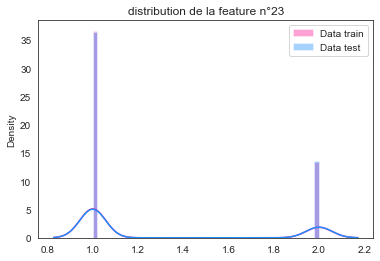

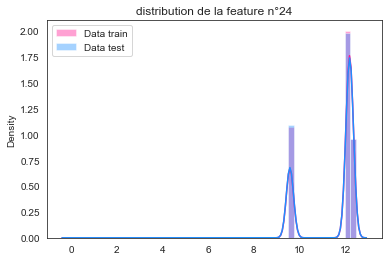

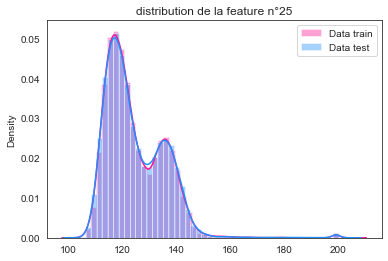

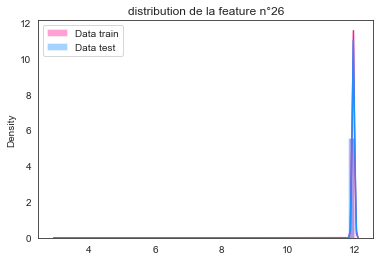

In [8]:
import seaborn as sns
sns.set_style("white")

i = 0
for k in X_test.T :
    bins  =50
    sns.distplot(X_train_full[:,i], bins = bins, color="deeppink", label="Data train")
    sns.distplot(X_test_full[:,i], bins = bins, color="dodgerblue", label="Data test")
    plt.title("distribution de la feature n°" + str(i))
    plt.legend()
    plt.show()
    i +=1


#### PCA

Dans cette seconde partie sur la data visualisation, nous allons tenter d'observer les données après l'application d'une PCA. Cette technique est souvent utilisé pour faire de la réduction de dimensionalité mais dans notre cas nous allons utiliser cette technique pour observer les données et vérifier qu'il n'y ait pas de pattern "simpl" à découvrir qui nous aiderait à traiter la problématique.

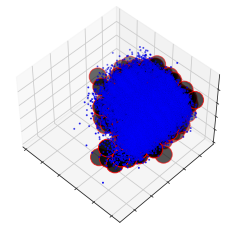

In [9]:
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib qt
from sklearn import decomposition

centers = [[1, 1], [-1, -1], [1, -1]]

X = X_train
y_train = y_train.ravel()
y = y_train

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)


ax.text3D(X_normal[:, 0].mean(),
          X_normal[:, 1].mean() + 1.5,
          X_normal[:, 2].mean(), 'Normal',
          horizontalalignment='center',
          bbox=dict(alpha=.5, edgecolor='b', facecolor='b'))

ax.text3D(X_anomally[:, 0].mean(),
          X_anomally[:, 1].mean() + 1.5,
          X_anomally[:, 2].mean(), 'Anomally',
          horizontalalignment='center',
          bbox=dict(alpha=.5, edgecolor='r', facecolor='r'))

# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X_normal[:, 0], X_normal[:, 1], X_normal[:, 2], c=ytrain[ytrain['Anomaly']==0], cmap=plt.cm.nipy_spectral,
           edgecolor='b', s=1)
ax.scatter(X_anomally[:, 0], X_anomally[:, 1], X_anomally[:, 2], c=ytrain[ytrain['Anomaly']==1], 
           cmap=plt.cm.nipy_spectral, edgecolor='r', s = 300)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

J'ai aussi tenté de faire de la visualisation pour voir si des patterns se déssinaient à l'aide de différent noyau pour la Kernel PCA. Je n'ai pas mis le code ici par souscis de lisibilité de mon rapport, et parce que je n'ai observé aucun pattern permettant facilement de discriminer les pièces normal des pièces possédant une anomalie.

# Suppression des outlier sur les données de test normales

Après l'échec de la PCA car les pièces possédant une anomalie semble "noyé" dans les pièces n'en possédant pas, j'ai tenté de supprimer les outliers des pièces mécanique n'étant pas classifié comme "anomalie". Je me suis en partie inspiré de cette article : https://kanoki.org/2020/04/23/how-to-remove-outliers-in-python/ .

J'ai trouvé deux solutions :
- la première, c'est de supprimer des données éloigné d'un certain quantile (j'ai supprimé les lignes dont une des données est éloigné de 1.5 le premier et troisième quartile) (IQR)
- la seconde méthode de suppression des outlier repose sur la distance de Mahalanobis (on fixe un seuil à partir duquel une donnée est estimé comme outlier)

# IQR

In [4]:
import numpy as np

IQR = []
for column in X_train_full.T :
    Q1 = np.quantile(column,0.25)
    Q3 = np.quantile(column,0.75)
    IQR.append((Q1 - 1.5*(Q3 - Q1), Q3 + 1.5*(Q3 - Q1)))

idx = []
index = 0
for line in X_train_full :
    if not index in index_anomally :
        k = 0
        for feature in line :
            if feature < IQR[k][0] or feature > IQR[k][1] :
                idx.append(index)
                break
            k+=1
    index +=1
print(len(idx)/len(X_normal))

X_train = np.delete(X_train, idx, axis=0)
y_train = np.delete(y_train, idx, axis=0)

0.17063919979176737


#### Suppression des outlier Mahalanobis

In [35]:
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data, axis=0)
    if not cov:
        cov = np.cov(data,rowvar=False)
    #la matrice de covariance n'est pas inversible. J'utilise donc la pseudo inverse 
    inv_covmat = np.linalg.pinv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

X_Mahala = mahalanobis(x=X_full, data=X_train)

idx = []
index = 0
for dist in X_Mahala :
    if not index in index_anomally :
        if dist > 30 :
            idx.append(index)
    index +=1
    

X_train = np.delete(X_train, idx, 0)
y_train = np.delete(y_train, idx, 0)

# Resampling

Enfin, et au vu de préparer le dataset pour les différents modèles que nous allons tester, j'ai testé des méthodes de resampling. Dans un premier cas, nous allons faire de l'undersampling, c'est à dire supprimer des données normal aléatoires. L'undersampling a permis d'augmenter légèrement l'accuracy des différents modèle. En effet, le dataset étant très désequilibré, il est difficile d'entrainer des modèles d'apprentissage supervisé dans cette situation.

Dans un second temps nous tenterons d'allier des méthodes d'under et d'over sampling. Mais ce qui a été le plus efficace dans notre problématique reste le random under sampling.

#### Random resampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train_re, y_resampled = rus.fit_resample(X_train, y_train)
print(X_train_re.shape)
print("Taux de pièces anormales :" + str(np.count_nonzero(y_train == 1) / len(y_train)))

#### Technique avancé de combinaison d'over et d'under resampling

J'ai tenté d'allier des techniques avancé d'over et under resampling de la bibliothèque imblearn. Cette étape de resampling n'a pas eu d'impact sur l'accuracy de mes modèles. La méthode d'over sampling est SMOTE et d'under sampling ENN pour le premier cas et l'under sampling Tomek dans le second cas.

In [13]:
from imblearn.combine import SMOTEENN 

sme = SMOTEENN()
X_train_re, y_train_re = sme.fit_resample(X_train, y_train)

In [13]:
from imblearn.combine import SMOTETomek 

sme = SMOTETomek()
X_train_re, y_train_re = sme.fit_resample(X_train, y_train)

# Split train test set

Je split dans certains cas la partie entrainement du modèle et validation du modèle dans le cas ou le modèle est gourmand et qu'il est très lent de faire de la cross validation.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

# Paramètres utiles

Pour certains modèles, le taux de contamination de notre dataset est important. En effet, il permettra d'affecter des poids aux données anormale et tentera de diminuer la difficulté d'apprentissage pour des algorithmes supervisé sur des dataset très désequilibré.

In [16]:
contamination = np.count_nonzero(y_train == 1) / len(y_train)
contamination

0.02512143841078808

# Modèles

Au début du datachallenge, j'ai commencé par explorer différents algorithmes de machine learning que nous avons étudié dans ce premier cours de machine learning. J'ai décidé de ne pas affiché tout les scores ainsi que toutes les cellules contenant tout les modèles de scikit learn, ce n'est pas très significatif ni interessant. Néanmoins, je peux faire un point sur les modèles sur lesquels je me suis concentré (ce qui m'a permis par la même occasion de me repencher sur les différents modèle). Pour mes révisions, je me suis appuyé sur la chaine de Josh Starmer : https://www.youtube.com/user/joshstarmer , ainsi que sur le matériel pédagogique accumulé lors des différents cours de MDI343.

Je me suis appuyer sur différents articles de la presse spécialisé ou des tutos sklearn pour tenter d'obtenir le meilleur modèle. (Exemple : https://scikit-learn.org/stable/modules/outlier_detection.html ; 

J'ai donc pu explorer beaucoup de modle disponible sur scikit-learn (liste non-exhaustive):
- KNN (en particulier en considérant la distance de Mahalanobis, a priori plus adapté pour la détection d'outlier)
- j'ai créé un classifieur basé sur la distance de Mahalanobis :

In [ ]:
class MahalanobisBinaryClassifier():
    def __init__(self, xtrain, ytrain):
        self.xtrain_pos = xtrain[ytrain == 1, :]
        self.xtrain_neg = xtrain[ytrain == 0, :]

    def predict_proba(self, xtest):
        pos_neg_dists = [(p,n) for p, n in zip(mahalanobis(xtest, self.xtrain_pos), mahalanobis(xtest, self.xtrain_neg))]
        return np.array([(1-n/(p+n), 1-p/(p+n)) for p,n in pos_neg_dists])

    def predict(self, xtest):
        return np.array([np.argmax(row) for row in self.predict_proba(xtest)])
clf = MahalanobisBinaryClassifier(X_train, y_train)        
y_predict2 = clf.predict_proba(X_val)
y_predict = clf.predict(X_val)

- J'ai testé les modèles classiques de regressions linéaires ainsi que la version un peu plus avancé comme ElasticNet qui mêle penalisation Ridge et Lasso
- J'ai testé les modèles de naive Bayes présent sur cette page https://scikit-learn.org/stable/modules/naive_bayes.html . En effet, nous avons vu dans le cours IA702 (Modèles probabilistes) que les modèles Bayésien ont de bien meilleurs performances sur des dataset désequilibré. Les performances sont relativement satisfaisante (environ 0.79 à l'AUC pour le modèle BayesianRidge).
- J'ai pu aussi testé différents modèle basé sur les arbre de décisions et l'Ensemble Learning, mais je n'ai pas obtenu de très bon résultat. J'avais pourtant pu lire que le modèle d'IsolationForest est plus adapté pour des problématiques d'outlier detection.
- J'ai aussi passé beaucoup de temps à tenter de thuner un MLP, en reprenant le code de notre DM2 à rendre en MDI343 et en ajoutant des couches / des neurones. Je pensais que cette technique serait efficace au vu du nombre d'exemple que nous avons. Malheureusement cette approche s'est averer infructueuse. Ai-je mal réglé le MLP ? Le nombre de données est-il insuffisant ? Le MLP est sur le papier un bon algorithme censé pouvoir approximer n'importe quel fonction mais en pratique il n'est pas efficace pour notre problématique. Vous trouverez le code pour le MLP dans la cellule suivante :

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

n_in = X_train.shape[1]
n_h1 = 8
n_h2 = 16
n_out = 1

nb_epoch = 3000
alpha = 0.01

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

torch.autograd.set_detect_anomaly(True)

W1 = torch.randn(n_in, n_h1) *0.01
W1.requires_grad = True
b1 = torch.zeros(n_h1, 1)
b1.requires_grad = True

W2 = torch.randn(n_h1, n_h2) *0.01
W2.requires_grad = True
b2 = torch.zeros(n_h2, 1)
b2.requires_grad = True

W3 = torch.randn(n_h2, n_out) *0.01
W3.requires_grad = True
b3 = torch.zeros(n_out, 1)
b3.requires_grad = True

class Net(torch.nn.Module):
    def __init__(self, n_in, n_h1, n_h2, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_h1) 
        self.fc2 = nn.Linear(n_h1, n_h2)
        self.fc3 = nn.Linear(n_h2, n_out)
        
    def forward(self, X):

        A0 = X
        A1 = F.relu(self.fc1(A0))
        A2 = F.relu(self.fc2(A1))
        A3 = torch.sigmoid(self.fc3(A2))

        return A3

my_model3 = Net(n_in, n_h1, n_h2, n_out)
criterion = nn.BCELoss()
optimizer = optim.Adagrad(my_model3.parameters(), lr=alpha)

loss_l = []
for num_epoch in range(nb_epoch):
  
    hat_y = my_model3(X_train.float())        
    loss = criterion(hat_y, y_train.float())
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
        
    loss_l.append(loss)

    if num_epoch % 500 == 0:
        print('epoch {}, loss {}'.format(num_epoch, loss.item()))

plt.plot(loss_l)   

In [ ]:
y_predict2 = my_model3(torch.from_numpy(X_val).float()).detach().numpy()
y_predict2

- J'ai aussi tenté des approches non supervisé pour la classification (Kmeans, clustering hiérarchique) sans obtenir des résultats très probant

Finalement, et suite à notre cours de MDI341 du 03/03/2020 je me suis penché sur les méthodes d'apprentissage semi-supervisé. Selon le professeur, des algorithme de Spectral Clustering peuvent être très efficace pour ce type de problématique. Malheureusement, la classe SpectralClustering de scikit learn n'a pas réussi à fitter mes données (ça prenait beaucoup trop de temps, soit il y a un problème dans ma compréhension de ce modele et de l'utilisation de la classe, soit ce modèle est trop gourmand pour notre problématique.)

J'ai alors essayé la bibliothèque pyod, spécialisé dans l'anomally detection et pleine d'algorithme d'apprentisage non supervisé et semi supervisé. La aussi le score stagnait à 0.8 (jusqu'à l'ajout de la colonne permettant de discriminer les lignes duppliquées), mais c'est grace à cette librairie que j'ai obtenu mes meilleurs scores d'AUC. Couplé à l'algorithme "star" des défis Kaggle, XGBoost j'ai réussi à monter jusqu'à 0.89 de score d'AUC.

Suite au choix du wrapper XGBoost de la bibliothèque pyod (https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.xgbod) couplé à 4 modèles d'apprentissage non supervisé :
- OCSVM (one class SVM muni d'un noyau polynomial de degré 5)
- IForest (isolation forest)
- HBOS (Histogram-based Outlier Detection)
- COPOD (copula-based outlier detection, a priori très utilisé en outlier detection)

L'apprentissage semi supervisé à l'avantage de me permettre d'exploiter les informations contenus dans le dataset de test : la distribution des données, tout en pouvant s'appuyer sur les labels du dataset X_train.

Afin de thuné les paramètres de XGBoost, j'ai utilisé la classe GridSearchCV de scikit learn.

In [ ]:
from pyod.models.xgbod import XGBOD
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD
from sklearn.model_selection import GridSearchCV

clf1 = OCSVM(kernel='poly', degree=5, gamma='scale', coef0=0.0, tol=0.001, nu=0.9, 
            shrinking=True, cache_size=200, verbose=False, max_iter=- 1, contamination=contamination)


clf2 = IForest(n_estimators=50, max_samples='auto', contamination=contamination, max_features=1.0, 
        bootstrap=True, n_jobs=1, behaviour='old')


clf3 = HBOS(n_bins=5, alpha=0.1, tol=0.5, contamination=contamination)


clf4 = COPOD(contamination = contamination)


estimator_list = [clf1, clf2, clf3, clf4]
clf = XGBOD(estimator_list=estimator_list)

parameters = {'booster':['gbtree', 'dart'], 'learning_rate':[0.03, 0.1], 'gamma' : [0, 0.5], 'max_depth':[3, 6]}
gs = GridSearchCV(clf, parameters, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)

In [23]:
gs.best_params_

{'booster': 'gbtree', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3}

In [24]:
gs.best_score_

0.8917225478582329

In [20]:
from pyod.models.xgbod import XGBOD
from pyod.models.ocsvm import OCSVM
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD

clf1 = OCSVM(kernel='poly', degree=5, gamma='scale', coef0=0.0, tol=0.001, nu=0.9, 
            shrinking=True, cache_size=200, verbose=False, max_iter=- 1, contamination=contamination)


clf2 = IForest(n_estimators=50, max_samples='auto', contamination=contamination, max_features=1.0, 
        bootstrap=True, n_jobs=1, behaviour='old')


clf3 = HBOS(n_bins=5, alpha=0.1, tol=0.5, contamination=contamination)


clf4 = COPOD(contamination = contamination)


estimator_list = [clf1, clf2, clf3, clf4]
clf = XGBOD(estimator_list=estimator_list, booster = 'gbtree', gamma = 0.5, learning_rate = 0.1, max_depth = 3)
clf.fit(X_train, y_train)

[22:10:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:10:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBOD(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1,
   estimator_list=[OCSVM(cache_size=200, coef0=0.0, contamination=0.02512143841078808, degree=5,
   gamma='scale', kernel='poly', max_iter=-1, nu=0.9, shrinking=True,
   tol=0.001, verbose=False), IForest(behaviour='old', bootstrap=True, contamination=0.02512143841078808,
    max_features=1.0, max_samples='auto', n_estimators=50, n_jobs=1,
    random_state=None, verbose=0), HBOS(alpha=0.1, contamination=0.02512143841078808, n_bins=5, tol=0.5), COPOD(contamination=0.02512143841078808)],
   gamma=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3,
   min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
   nthread=None, objective='binary:logistic', random_state=0, reg_alpha=0,
   reg_lambda=1, scale_pos_weight=1, silent=True,
   standardization_flag_list=[True, True, True, True], subsample=1)

# Calcul des performance

#### AUC et ROC

Cette partie est utile si j'ai divisé le trainset à l'aide de train_test_split de sklearn, autrement je n'utilise pas cette fonction sur le set d'entrainement (trop dépendant à l'overfitting).

In [24]:
from sklearn.metrics import roc_auc_score
decif = clf.predict_proba(X_val)
roc_auc_score(y_val, decif)

0.895263619579963

In [28]:
import matplotlib.pyplot as plt  
from sklearn import metrics

metrics.plot_roc_curve(clf, X_val, y_val)  
plt.show()

#### Cross validation

En fonction du mmodèle, si la cross validation n'est pas trop longue, j'execute la cross val. Dans le cas contraire, je me contente de faire un trian test split puis d'observer le score d'AUC sur le set de validation

In [29]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_train, y_train,scoring='roc_auc', cv=5)

[22:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:16:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

array([0.89506221, 0.8700745 , 0.89709927, 0.88881634, 0.89809245])

# Import score leaderboard

Predict_proba ou decision_function en fonction du modèle et de la librairie utilisé.

In [18]:
decif = clf.predict_proba(X_test)
np.savetxt('ytest_challenge_student.csv', decif, fmt = '%1.6f', delimiter=',')

Merci pour l'attention porter à mon rapport !